# Task 2 - LSTM for time series classification

In [0]:
import numpy as np
import pandas as pd
import re
import os

from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
sns.set_style("darkgrid")
sns.set(font_scale=1.3)

In [47]:
# GPU
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.6 GB  | Proc size: 485.7 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


## Data import & EDA

In [48]:
files.upload()

{}

In [49]:
FILE_NAME_PREFIX = 'Ambient_Living_'
data_file_pattern = FILE_NAME_PREFIX + r'(?P<seq_id>\d+).csv'
data_files = list(filter(lambda s: re.match(data_file_pattern, s) is not None, os.listdir()))
N_FILES = len(data_files)
N_FILES

15

In [50]:
seq_ids = sorted(int(re.match(data_file_pattern, file_name).group('seq_id')) for file_name in data_files)
print(seq_ids)

[202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216]


In [0]:
def load_file(file_code, strip=False):
    df = pd.read_csv(f'{FILE_NAME_PREFIX}{file_code}.csv')
    
    if strip:
        df.columns = [c.strip() for c in df.columns]
    
    return df

### Data example

In [52]:
seq_id = seq_ids[0]
data_example = load_file(seq_id)
data_example.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
0,0.090909,-0.288890,-0.200000,-0.106380
1,0.090909,-0.155560,-0.200000,0.021277
2,0.090909,-0.511110,-0.066667,0.021277
3,0.090909,0.066667,-0.066667,0.021277
4,-0.181820,-0.022222,0.066667,0.191490


In [53]:
data_example.describe()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
count,56.000000,56.000000,56.000000,56.000000
mean,-0.421267,-0.480953,0.327778,0.231005
std,0.287413,0.227115,0.393168,0.246509
min,-0.863640,-1.000000,-0.600000,-0.319150
25%,-0.693182,-0.600000,0.044445,0.053192
50%,-0.454550,-0.488890,0.377780,0.191490
75%,-0.181820,-0.333330,0.733330,0.404260
max,0.090909,0.066667,0.866670,0.744680


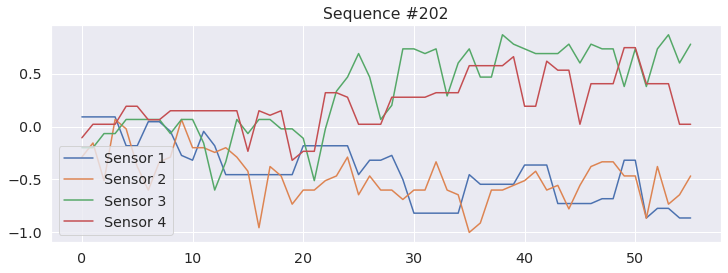

In [54]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=data_example, dashes=False)
_ = ax.set_title(f"Sequence #{seq_id}")

### Targets - class labels

In [55]:
# load targets (class labels) for available sequences (only those which have been uploaded)
targets = load_file('target', True).iloc[np.array(seq_ids)-1]
targets.head()

,#sequence_ID,class_label
201,202,1
202,203,1
203,204,-1
204,205,-1
205,206,-1


In [56]:
targets['class_label'].value_counts()  # number of classes, class labels, number of examples per class

-1    13
 1     2
Name: class_label, dtype: int64

In [0]:
all_labels = ((targets['class_label'].values + 1)/2).astype("int32")

### All data files

In [0]:
# load data for the available sequences
all_data = [load_file(i) for i in seq_ids]


In [59]:
descr = targets['class_label'].to_frame()
descr.index=targets['#sequence_ID']
descr['length'] = [d.shape[0] for d in all_data]
descr['n_features'] = [d.shape[1] for d in all_data]
descr.head()

,class_label,length,n_features
#sequence_ID,,,
202,1,56,4
203,1,63,4
204,-1,51,4
205,-1,41,4
206,-1,42,4


In [60]:
descr[descr.columns[1:]].describe(percentiles=np.arange(0.2, 1, 0.2))

,length,n_features
count,15.000000,15.0
mean,44.600000,4.0
std,7.038669,0.0
min,37.000000,4.0
20%,40.000000,4.0
40%,41.600000,4.0
50%,42.000000,4.0
60%,44.000000,4.0
80%,46.200000,4.0
max,63.000000,4.0


## Pre-processing
### Adjust sequence lengths to the global 80th quantile

In [61]:
q_cut = 0.8  # cut the length at the 80th quantile
q_cut_value = int(descr['length'].quantile(q_cut))  # get the length corresponding to the quantile
q_cut_value

46

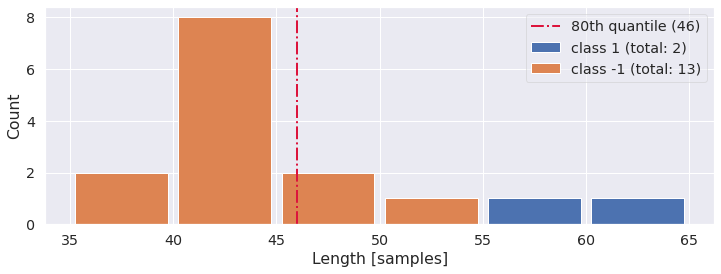

In [62]:
fig, ax = plt.subplots(figsize=(12,4))

w = 5
ln = descr['length']
labels_set = descr['class_label'].unique()
lengths_classes = [ln[descr['class_label'] == label] for label in labels_set]

hist = ax.hist(lengths_classes,
               bins=range(w*(min(ln)//w), max(ln)+w, w),
               label=[f'class {label} (total: {len(lengths_classes[i])})' for i, label in enumerate(labels_set)],
               stacked=True, rwidth=0.9)

ax.axvline(q_cut_value, color='crimson', linestyle='-.', lw=2, label=f'{100*q_cut:.0f}th quantile ({q_cut_value})')

ax.legend(fancybox=True, framealpha=0.5)
ax.set_xlabel("Length [samples]")
ax.set_ylabel("Count")
plt.show()

In [0]:
# prepare array for the pre-processed data (216x54x4)
all_data_prep = np.zeros((len(all_data), q_cut_value, all_data[0].shape[1]))

# fill the array with data for cropped sequences (the padding to 0 is automatic by non-filling the already zero-filled rows)
for i, sequence in enumerate(all_data):
    all_data_prep[i, :min(q_cut_value, sequence.shape[0]), :] = sequence.iloc[:q_cut_value, :]

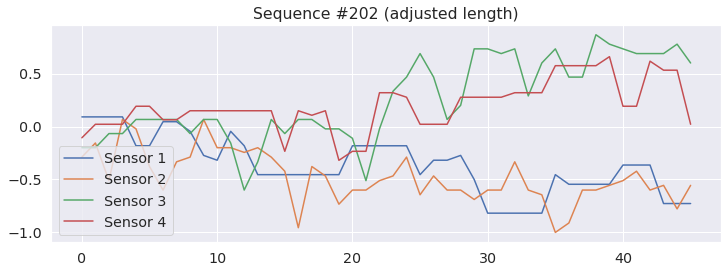

In [64]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=all_data_prep[0], dashes=False)
_ = ax.set_title(f"Sequence #{seq_id} (adjusted length)")
_ = ax.legend(data_example.columns)

## LSTM

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score


In [0]:
# a function defining a model to be evaluated (after wrapping by the Keras)
def make_lstm(my_lstm_units, my_lr):
    lstm_model = Sequential()
    lstm_model.add(layers.LSTM(my_lstm_units, input_shape=all_data_prep.shape[1:]))
    lstm_model.add(layers.Dense(1, activation='sigmoid'))
    
    adam = Adam(lr=my_lr)
    lstm_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return lstm_model

fit_params = dict(epochs=100, batch_size=N_FILES//6)
sk_params = dict(**fit_params, my_lstm_units=256, my_lr=0.001)


In [0]:
# define the 10-fold cross-validation split
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [0]:
kc = KerasClassifier(make_lstm, **sk_params)


In [0]:
# define a scoring function for the cross validation
def scorer(estimator, X, y):
    return accuracy_score((estimator.predict(X) > 0.5).astype("int32"), y) 


In [0]:
# run the cross-validation
# scores = cross_val_score(KerasClassifier(make_lstm, **sk_params), X=all_data_prep, y=all_labels, cv=kf, scoring=scorer)


In [71]:
# scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Grid search

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
param_grid = {'my_lr': [0.001, 0.1], 'batch_size': [N_FILES, N_FILES//6], 'my_lstm_units': [128, 256]}

In [156]:
gcv = GridSearchCV(KerasClassifier(make_lstm, **fit_params), param_grid=param_grid, cv=kf, scoring=scorer)
gcv

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f20171b8400>,
             iid='deprecated', n_jobs=None,
             param_grid={'batch_size': [15, 2], 'my_lr': [0.001, 0.1],
                         'my_lstm_units': [128, 256]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function scorer at 0x7f206804d7b8>, verbose=0)

In [157]:
gcv.fit(all_data_prep, all_labels)

Epoch 69/100
7/7 [==============================] - 0s 5ms/step - loss: 0.7486 - accuracy: 0.8571
Epoch 70/100
7/7 [==============================] - 0s 4ms/step - loss: 1.4360 - accuracy: 0.7143
Epoch 71/100
7/7 [==============================] - 0s 4ms/step - loss: 0.7380 - accuracy: 0.5714
Epoch 72/100
7/7 [==============================] - 0s 4ms/step - loss: 0.9422 - accuracy: 0.8571
Epoch 73/100
7/7 [==============================] - 0s 4ms/step - loss: 0.5855 - accuracy: 0.5714
Epoch 74/100
7/7 [==============================] - 0s 4ms/step - loss: 0.5691 - accuracy: 0.8571
Epoch 75/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5714
Epoch 76/100
7/7 [==============================] - 0s 4ms/step - loss: 1.6248 - accuracy: 0.8571
Epoch 77/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8229 - accuracy: 0.8571
Epoch 78/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.5714
Epoch 79/100
7/7 [==

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f20171b8400>,
             iid='deprecated', n_jobs=None,
             param_grid={'batch_size': [15, 2], 'my_lr': [0.001, 0.1],
                         'my_lstm_units': [128, 256]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function scorer at 0x7f206804d7b8>, verbose=0)

In [158]:
gcv.best_params_

{'batch_size': 15, 'my_lr': 0.001, 'my_lstm_units': 256}

In [159]:
gcv.best_score_

1.0

In [160]:
gcv.cv_results_

{'mean_fit_time': array([3.98709185, 3.97860601, 3.88172297, 3.85898218, 6.63197458,
        6.6452323 , 6.46778839, 6.59929974]),
 'mean_score_time': array([0.42921324, 0.43060691, 0.49881136, 0.41829624, 0.41032112,
        0.40023963, 0.40671263, 0.40404751]),
 'mean_test_score': array([0.9 , 1.  , 0.95, 0.9 , 1.  , 0.9 , 1.  , 0.95]),
 'param_batch_size': masked_array(data=[15, 15, 15, 15, 2, 2, 2, 2],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_my_lr': masked_array(data=[0.001, 0.001, 0.1, 0.1, 0.001, 0.001, 0.1, 0.1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_my_lstm_units': masked_array(data=[128, 256, 128, 256, 128, 256, 128, 256],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 15, 'my_

In [161]:
gcv.cv_results_['mean_test_score']

array([0.9 , 1.  , 0.95, 0.9 , 1.  , 0.9 , 1.  , 0.95])

In [0]:
cvr = gcv.cv_results_

In [0]:
codes = ['my_lr', 'batch_size', 'my_lstm_units']


Text(0.5, 0, 'my_lstm_units')

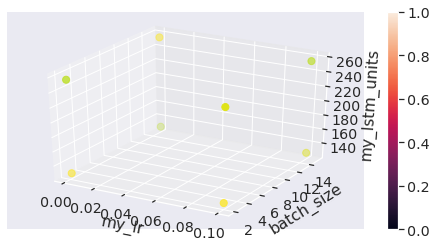

In [165]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(*tuple(cvr[f'param_{code}'].data.astype(float) for code in codes),
               color=plt.cm.viridis(cvr['mean_test_score']), marker='o', s=50)
fig.colorbar(p)

ax.set_xlabel(codes[0])
ax.set_ylabel(codes[1])
ax.set_zlabel(codes[2])